## Module 4 Final Project - Computer Vision

* Student name: Emily J. Cain
* Student pace: Full Time
* Scheduled project review date: Tuesday, February 26, 2019 
* Instructor name: Rafael Carrasco
* Blog post URL: https://medium.com/@magicmilly

For the optimal Notebook viewing experience, enable [nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) for Table of Contents and Collapsible Headings.

## Objective: Train a Convolutional Neural Network to Classify Retinal Scans
The images used as data for this project were obtained from Optical Coherence Tomography (OCT), which is a non-invasive diagnostic test used for examining cross-sections of the retina, though this technology is also applied in other medical and research fields. The images fall into one of four classes:
* **CNV** - Choroidal neovascularization - the abnormal growth of blood vessels beneath the retina. CNV is associated with many conditions, including some forms of myopia and macular degeneration. CNV can cause vision distortions and deterioration. 
* **DME** - Diabetic macular edema - a symptom of diabetic retinopathy that causes fluid build-up within the retina. DME is the most common cause of vision loss associated with poorly-controlled and advanced diabetes. Other types of macular edema exist that are not associated with diabetes.
* **Drusen** - fatty deposits under the retina - some types of drusen may affect vision and increase the risk for macular degeneration, while other types may never cause any noticeable problems for the patient.
* **Normal** - no abnormalities present

In [1]:
import cv2
import datetime
import h5py
import numpy as np
import os
import pandas as pd
import warnings

from collections import Counter
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import load_model, Sequential
from keras.utils import to_categorical 
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings(action='ignore', category=FutureWarning)

/anaconda3/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


## I. Custom Functions Used

#### Append results DataFrame to easily compare model attributes and results.

In [22]:
def append_df(df, idx, results_list):
    
    """
    Manually append existing dataframe by specifying index and results from model.
    Returns updated dataframe with new results row.
    """
    
    df.loc[idx] = results_list
    return df

#### Print train and test metrics

In [52]:
def print_metrics(model, X_train, y_train, X_test, y_test):
    
    """
    Print training and test metrics from model.
    Longer runtime for more computationally expensive models.
    """
    
    print(f'Training loss: {model.evaluate(X_train, y_train)[0]}')
    print(f'Training accuracy: {model.evaluate(X_train, y_train)[1]}')
    print(f'Test loss: {model.evaluate(X_test, y_test)[0]}')
    print(f'Test accuracy: {model.evaluate(X_test, y_test)[1]}')

#### Plot accuracy and loss vs. epochs for training and validation sets.

In [59]:
def plot_acc_and_val(history):
    
    """
    Given a model's history with accuracy and loss values, returns a plot showing training accuracy, validation
    accuracy, training loss, and validation loss.
    """
    
    fig = plt.figure(figsize=(8,6))

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs, loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss & Accuracy')
    plt.legend(loc='best')
    plt.show()

#### Plot confusion matrix

In [111]:
def plot_confusion_matrix(y_preds, y_test):
    
    """
    Plot heatmap of confusion matrix to show true vs. predicted labels.
    
    Arguments: predicted y values from model.predict() and true y values
    
    Y values are reversed from one-hot encoding to integers representing the 
    index of class labels and used to produce confusion matrix. Confusion matrix 
    is converted to pandas DataFrame and then plotted as a Seaborn heatmap with 
    class labels.
    
    Returns: Confusion matrix heatmap figure
    
    """
    y_preds_reversed = [np.argmax(y, axis=None, out=None) for y in y_preds]
    y_test_reversed = [np.argmax(y, axis=None, out=None) for y in y_test]
    
    class_names = ['normal', 'cnv', 'dme', 'drusen']
    
    cm = confusion_matrix(y_test_reversed, y_preds_reversed)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig = plt.figure(figsize=(8,6))
    hm = sns.heatmap(data=df_cm, annot=True, cbar=True, cmap='YlGnBu', linewidths=0.5, fmt='d')
    hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0)
    hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=45)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

Thanks to [shaypal5](https://gist.github.com/shaypal5) for pretty print confusion matrix function

## II. Load & Inspect Original Image Data

#### Image Counts

In [10]:
# calculate amount of images
cnv_imgs = len(os.listdir('Data/cnv'))
dme_imgs = len(os.listdir('Data/dme'))
drusen_imgs = len(os.listdir('Data/drusen'))
normal_imgs = len(os.listdir('Data/normal'))

total_imgs = cnv_imgs + dme_imgs + drusen_imgs + normal_imgs
print(f'{cnv_imgs} CNV images')
print(f'{dme_imgs} DME images')
print(f'{drusen_imgs} Drusen images')
print(f'{normal_imgs} normal images')
print(f'There are {total_imgs} total images.')

37216 CNV images
11422 DME images
8620 Drusen images
26348 normal images
There are 83606 total images.


#### Inspect image with original size

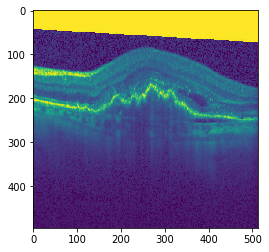

In [3]:
test_img = Image.open('Data/cnv/CNV-6294785-1.jpeg')
# test_img.show() - this opens image in new window
imshow(np.asarray(test_img)); # imshow for inline image

#### Images from Each Class

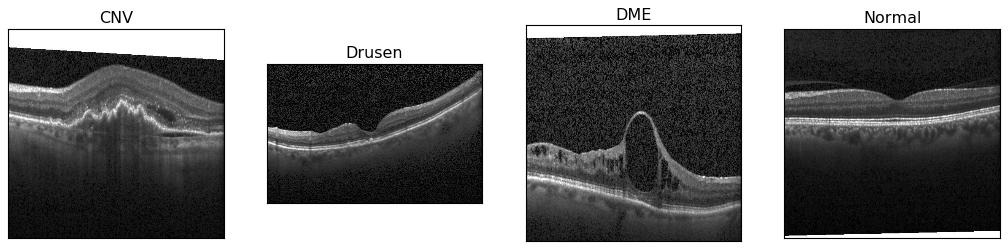

In [48]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4))
fig.patch.set_facecolor('white')

original_cnv = Image.open('Data/cnv/CNV-6294785-1.jpeg')
ax1.imshow(np.asarray(original_cnv))
ax1.set_title('CNV')
ax1.set(xticks=[], yticks=[])

original_drusen = Image.open('Data/drusen/DRUSEN-66861-1.jpeg')
ax2.imshow(np.asarray(original_drusen))
ax2.set_title('Drusen')
ax2.set(xticks=[], yticks=[])

original_dme = Image.open('Data/dme/DME-30521-46.jpeg')
ax3.imshow(np.asarray(original_dme))
ax3.set_title('DME')
ax3.set(xticks=[], yticks=[])

original_normal = Image.open('Data/normal/NORMAL-9771248-3.jpeg')
ax4.imshow(np.asarray(original_normal))
ax4.set_title('Normal')
ax4.set(xticks=[], yticks=[])

plt.show();

#### Class Distribution

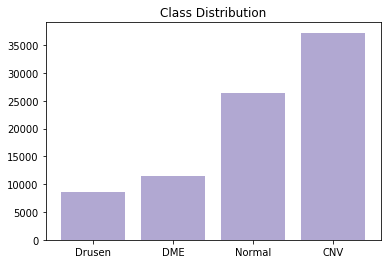

In [11]:
fig = plt.figure()
fig.patch.set_facecolor('white')
x = np.arange(4)
labels = ['Drusen', 'DME', 'Normal', 'CNV']
amounts = [drusen_imgs, dme_imgs, normal_imgs, cnv_imgs]

plt.bar(x, amounts, align='center', color='#B1A8D2')
plt.xticks(x, labels)
plt.title('Class Distribution')
plt.show()

## III. Preprocess Data
* Resize
* Label
* Reshape for model input
* Split data into features (X) and labels (y)
* Normalize pixel values
* One-hot encode labels
* Train-test-split data into training and (holdout) test data

### A. Resize and label images

Run cell below to create resized images as list `data`. If `data` already exists, the cell will not run again. Adjust `img_size` as needed.

In [2]:
img_classes = ['normal', 'cnv', 'dme', 'drusen']
img_size = 50
original_dir = 'Data'

# keep myself from re-creating this list if it already exists 
try:
    data = data
    print('Data already exists in this dimension')
    print(len(data))
except NameError: 
    data = None
    print('Re-loading images')
    
if data is None:
    data = []
    for img_class in img_classes:

        path = os.path.join(original_dir, img_class)
        # assign numeric value to class labels
        class_num = img_classes.index(img_class)

        for img in os.listdir(path):

            file = os.path.join(path, img)
            # if-else keeps .DS_store from throwing an error
            if file.endswith('.jpeg'):
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # resize images to (40,40)
                resize_array = cv2.resize(img_array, (img_size, img_size))
                # create new data list of resized images with their class labels
                data.append([resize_array, class_num])
            else:
                print(file)

Re-loading images
Data/normal/.DS_Store


In [25]:
# Confirm image size
data[0][0].shape

(50, 50)

### B. Save & Load Images

Save images as `.npy` file within `Data` folder so that they can be re-loaded later. Images will re-load automatically as a numpy array but must be assigned manually for immediate use. 

In [26]:
np.save('Data/img_array_50', data)

In [8]:
data = np.array(data)

In [9]:
# Check array dimensions
data.shape

(83605, 2)

Re-load images by assigning variable name and check shape to confirm.

In [2]:
data = np.load("./Data/img_array_50.npy")
data.shape

(83605, 2)

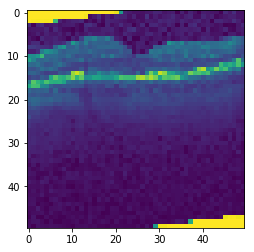

In [3]:
imshow(data[0][0]);

In [4]:
data[0][0].shape

(50, 50)

In [5]:
data[0].shape

(2,)

### C. Split data into features and labels 

In [6]:
X = []
y = []

for feature, label in data:
    # normalize image values by max value of 255
    X.append(feature/255)
    y.append(label)

In [7]:
len(X)

83605

In [8]:
len(y)

83605

In [9]:
# Confirm normalized pixel values
print(X[1])

[[1.         1.         1.         ... 0.07058824 0.10196078 0.01176471]
 [1.         0.63921569 0.65490196 ... 0.12941176 0.13333333 0.01960784]
 [0.16862745 0.09019608 0.1254902  ... 0.1372549  0.17254902 0.14117647]
 ...
 [0.07058824 0.05490196 0.0627451  ... 0.05882353 0.05882353 0.03137255]
 [0.05098039 0.07843137 0.0745098  ... 0.6        0.60784314 1.        ]
 [0.0627451  0.02352941 0.05490196 ... 1.         1.         1.        ]]


### D. Reshape Images for Modeling

In [10]:
img_size = 50
X = np.array(X).reshape(-1, img_size, img_size, 1)

In [11]:
X.shape

(83605, 50, 50, 1)

### E. One-hot encode labels

In [12]:
y = to_categorical(y, num_classes=4)

In [13]:
y.shape

(83605, 4)

### F. Split Data into Training and Test sets

Test / holdout set was decreased for later models to allow for a larger training set and to reduce overfitting.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=0.1)

In [15]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (75244, 50, 50, 1)
y_train shape: (75244, 4)
X_test shape: (8361, 50, 50, 1)
y_test shape: (8361, 4)


## IV. Convolutional Neural Networks

### Model 1 
* 3 convolutional layers
* 1 dense layer (not including output)

In [35]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=X.shape[1:], activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (4,4), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# Flatten() because Dense layers only like 1D data
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

#### Model Summary

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        16416     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
__________

In [37]:
start = datetime.datetime.now()

# batch_size default = 32
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)
elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/30
53507/53507 [==============================] - 58s 1ms/step - loss: 0.7637 - acc: 0.7091 - val_loss: 0.5662 - val_acc: 0.7889
Epoch 2/30
53507/53507 [==============================] - 57s 1ms/step - loss: 0.5258 - acc: 0.8058 - val_loss: 0.4756 - val_acc: 0.8238
Epoch 3/30
53507/53507 [==============================] - 54s 1ms/step - loss: 0.4472 - acc: 0.8366 - val_loss: 0.4626 - val_acc: 0.8343
Epoch 4/30
53507/53507 [==============================] - 56s 1ms/step - loss: 0.3993 - acc: 0.8549 - val_loss: 0.4218 - val_acc: 0.8440
Epoch 5/30
53507/53507 [==============================] - 55s 1ms/step - loss: 0.3654 - acc: 0.8672 - val_loss: 0.3893 - val_acc: 0.8562
Epoch 6/30
53507/53507 [==============================] - 55s 1ms/step - loss: 0.3366 - acc: 0.8783 - val_loss: 0.3836 - val_acc: 0.8626
Epoch 7/30
53507/53507 [==============================] - 56s 1ms/step - loss: 0.3126 - acc: 0.8862 - val_loss: 0.3889 - val_acc

#### Model Details & Results
Pandas DataFrame to keep track of model details, results, and training times - to be appended with each new model.

In [23]:
columns = ['img_size', 'num_conv_layers', 'num_dense_layers', 'extras', 'epochs', 'acc', 'loss', 'val_acc', 'val_loss', 'time']
df = pd.DataFrame(columns=columns)
df

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time


In [24]:
model_1_results = [40, 3, 1, 'None', 30, 0.97, 0.08, 0.86, 0.72, 28]
append_df(df, 0, model_1_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28


#### Train & Test Metrics

In [42]:
print_metrics(model, X_train, y_train, X_test, y_test)

66884/66884 [==============================] - 17s 253us/step
Training loss: 0.21424882945278623
66884/66884 [==============================] - 17s 253us/step
Training accuracy: 0.9441121942467556
16721/16721 [==============================] - 4s 259us/step
Test loss: 0.7160191144626018
16721/16721 [==============================] - 4s 259us/step
Test accuracy: 0.8564679146019738


#### Accuracy & Loss vs. Epochs

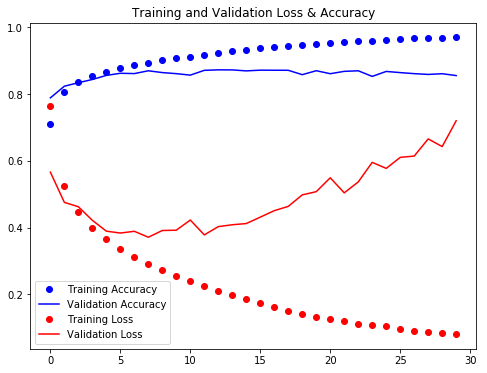

In [52]:
plot_acc_and_val(history)

#### Model 1 Observations

The first model performed well on the training data at 97% accuracy but experienced overfitting with a validation and testing accuracy of 86%. Training for 30 epochs with no regularization parameters or callbacks most likely led to overfitting. The above plot also clearly shows that the model kept training as the validation loss increased. Will try using kernel regularization and early stopping on the next model to find a better fit. A kernel size of (4,4) is probably too large for early, untuned models.

In [53]:
# model.save('Models/first_model_no_tuning.h5')

#### Initiate Callbacks
* Reduce learning rate when the specified threshold for validation loss is not achieved
* Stop training when there has been no decrease in validation loss for 7 epochs

In [45]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001)

early_stoppage = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=7, 
                               verbose=1, 
                               mode='auto', 
                               baseline=None, 
                               restore_best_weights=False)

### Model 2 
* Add zero padding
* Use L2 Regularization to reduce overfitting
* Apply callbacks

In [47]:
model_2 = Sequential()
model_2.add(Conv2D(64, (2,2), 
                 input_shape=X.shape[1:], 
                 activation='relu', 
                 padding='same', 
                 kernel_regularizer=regularizers.l2(0.01)))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(32, (2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(MaxPooling2D(2,2))

model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(4, activation='softmax'))

In [48]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [51]:
start = datetime.datetime.now()

history = model_2.fit(X_train, y_train, 
                    callbacks=[reduce_lr, early_stoppage], 
                    epochs=20, 
                    batch_size=32,
                    validation_split=0.2)

elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/20
53507/53507 [==============================] - 89s 2ms/step - loss: 0.9482 - acc: 0.6472 - val_loss: 0.8791 - val_acc: 0.6803
Epoch 2/20
53507/53507 [==============================] - 85s 2ms/step - loss: 0.7181 - acc: 0.7451 - val_loss: 0.6764 - val_acc: 0.7591
Epoch 3/20
53507/53507 [==============================] - 82s 2ms/step - loss: 0.6568 - acc: 0.7669 - val_loss: 0.6433 - val_acc: 0.7725
Epoch 4/20
53507/53507 [==============================] - 86s 2ms/step - loss: 0.6267 - acc: 0.7800 - val_loss: 0.6887 - val_acc: 0.7562
Epoch 5/20
53507/53507 [==============================] - 86s 2ms/step - loss: 0.5996 - acc: 0.7885 - val_loss: 0.6019 - val_acc: 0.7846
Epoch 6/20
53507/53507 [==============================] - 85s 2ms/step - loss: 0.5769 - acc: 0.7970 - val_loss: 0.5798 - val_acc: 0.7986
Epoch 7/20
53507/53507 [==============================] - 84s 2ms/step - loss: 0.5491 - acc: 0.8083 - val_loss: 0.5628 - val_acc

#### Comparison to Previous Models

In [28]:
model_2_results = [40, 3, 2, 'callbacks', 20, 0.87, 0.40, 0.84, 0.49, 26]
append_df(df, 1, model_2_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26


#### Accuracy & Loss vs. Epochs

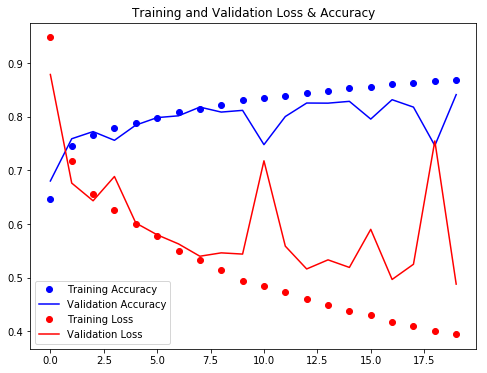

In [52]:
plot_acc_and_val(history)

Plot indicates that more epochs could improve performance as long as measures are taken to combat overfitting.

#### Test Metrics

In [57]:
model_2.evaluate(X_test, y_test)

16721/16721 [==============================] - 6s 362us/step


[0.49538368569678876, 0.837928353570935]

#### Model 2 Observations
Model 2 looks better with goodness of fit - the training accuracy decreased, and the training loss increased, but these values were much closer to the validation and test metrics. Model 3 can focus on increased accuracy overall with the parameters that helped reduce overfitting in Model 2.

In [53]:
model_2.save('Models/model_2_with_tunings.h5')

### Model 3
* Increase epochs
* Add a convolutional layer

In [54]:
model_3 = Sequential()
model_3.add(Conv2D(64, (2,2), 
                 input_shape=X.shape[1:], 
                 activation='relu', 
                 padding='same', 
                 kernel_regularizer=regularizers.l2(0.01)))
model_3.add(MaxPooling2D(2,2))

model_3.add(Conv2D(32, (2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(MaxPooling2D(2,2))

model_3.add(Conv2D(64, (3,3), activation='relu'))
model_3.add(MaxPooling2D(2,2))

model_3.add(Conv2D(32, (2,2), activation='relu', padding='same'))
model_3.add(MaxPooling2D(2,2))

model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(4, activation='softmax'))

In [55]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [58]:
start = datetime.datetime.now()

history_3 = model_3.fit(X_train, y_train, 
                    callbacks=[reduce_lr, early_stoppage], 
                    epochs=30, 
                    batch_size=32,
                    validation_split=0.2)

elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/30
53507/53507 [==============================] - 74s 1ms/step - loss: 0.9905 - acc: 0.6196 - val_loss: 0.8608 - val_acc: 0.6910
Epoch 2/30
53507/53507 [==============================] - 71s 1ms/step - loss: 0.7326 - acc: 0.7385 - val_loss: 0.6678 - val_acc: 0.7627
Epoch 3/30
53507/53507 [==============================] - 71s 1ms/step - loss: 0.6667 - acc: 0.7631 - val_loss: 0.6428 - val_acc: 0.7694
Epoch 4/30
53507/53507 [==============================] - 70s 1ms/step - loss: 0.6340 - acc: 0.7755 - val_loss: 0.6019 - val_acc: 0.7846
Epoch 5/30
53507/53507 [==============================] - 71s 1ms/step - loss: 0.6029 - acc: 0.7872 - val_loss: 0.5898 - val_acc: 0.7920
Epoch 6/30
53507/53507 [==============================] - 71s 1ms/step - loss: 0.5831 - acc: 0.7964 - val_loss: 0.5733 - val_acc: 0.7969
Epoch 7/30
53507/53507 [==============================] - 73s 1ms/step - loss: 0.5669 - acc: 0.8003 - val_loss: 0.5719 - val_acc

#### Comparison to Previous Models

In [30]:
model_3_results = [40, 4, 2, 'l2 reg', 30, 0.87, 0.40, 0.84, 0.48, 36]
append_df(df, 2, model_3_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36


#### Test Metrics

In [60]:
model_3.evaluate(X_test, y_test)

16721/16721 [==============================] - 6s 374us/step


[0.48898925440682584, 0.8396626996028709]

#### Model 3 Observations
The changes to Model 3 had very little effect on model performance.

In [61]:
model_3.save('Models/model_3_extra_layer_epochs.h5')

### Model 4
* Sequentially increase number of filters per layer (somewhat like the VGG models)
* Add another convolutional layer
* Replace L2 regularization with dropout regularization

In [9]:
model_4 = Sequential()
model_4.add(Conv2D(64, (3,4), 
                 input_shape=X.shape[1:], 
                 activation='relu', 
                 padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(4, activation='softmax'))

In [10]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [13]:
start = datetime.datetime.now()

model_4.fit(X_train, y_train,
           batch_size=32,
           epochs=25,
           validation_split=0.2,
           callbacks=[reduce_lr, early_stoppage])

elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/25
53507/53507 [==============================] - 251s 5ms/step - loss: 0.9948 - acc: 0.6023 - val_loss: 0.7263 - val_acc: 0.7160
Epoch 2/25
53507/53507 [==============================] - 261s 5ms/step - loss: 0.7204 - acc: 0.7293 - val_loss: 0.6581 - val_acc: 0.7621
Epoch 3/25
53507/53507 [==============================] - 252s 5ms/step - loss: 0.6417 - acc: 0.7752 - val_loss: 0.5745 - val_acc: 0.7940
Epoch 4/25
53507/53507 [==============================] - 241s 5ms/step - loss: 0.5732 - acc: 0.8014 - val_loss: 0.5112 - val_acc: 0.8124
Epoch 5/25
53507/53507 [==============================] - 246s 5ms/step - loss: 0.5338 - acc: 0.8131 - val_loss: 0.4936 - val_acc: 0.8168
Epoch 6/25
53507/53507 [==============================] - 257s 5ms/step - loss: 0.4977 - acc: 0.8245 - val_loss: 0.4707 - val_acc: 0.8230
Epoch 7/25
53507/53507 [==============================] - 259s 5ms/step - loss: 0.4689 - acc: 0.8345 - val_loss: 0.4430 - 

#### Comparison to Previous Models

In [44]:
model_4_results = [40, 5, 2, 'dropout', 20, 0.90, 0.29, 0.86, 0.48, '1:29']
append_df(df, 3, model_4_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36
3,40,5,2,dropout,20,0.90,0.29,0.86,0.48,1:29


#### Test Metrics

In [14]:
model_4.evaluate(X_test, y_test)

16721/16721 [==============================] - 14s 816us/step


[0.4644889997112417, 0.8591591412032537]

#### Model 4 Observations
Accuracy increased with added conv layers and more filters, and by replacing L2 regularization with dropout.
Training loss also decreased. Val_acc slightly increased. Val_loss stayed the same. The highest accuracy (but with the most overfitting) was observed in initial model - which was the only model with only 1 dense layer but no regularization, callbacks, or dropout. Model 1 also used the largest kernel size of (4,4) in one of its conv layers. Will try using larger 50x50 images with an architecture similar to Model 1 but with dropout and more filters, similar to Model 4. 

In [15]:
model_4.save('Models/model_4_larger_filters.h5')

### Model 5
* 1 dense layer with dropout
* more filters in conv layers
* larger kernel size in second conv layer
* callbacks
* larger validation set (validation split will stay the same, but training data overall is larger due to smaller holdout set)

In [46]:
model_5 = Sequential()
model_5.add(Conv2D(64, (3,3), 
                  input_shape=X.shape[1:], 
                  activation='relu'))
model_5.add(MaxPooling2D(2,2))

model_5.add(Conv2D(64, (4,4), activation='relu'))
model_5.add(MaxPooling2D(2,2))

model_5.add(Conv2D(128, (3,3), activation='relu'))
model_5.add(MaxPooling2D(2,2))

model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(4, activation='softmax'))

#### Model Summary

In [51]:
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [47]:
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [48]:
start = datetime.datetime.now()

history_5 = model_5.fit(X_train, y_train,
                       validation_split=0.2,
                       callbacks=[reduce_lr, early_stoppage],
                       batch_size=32,
                       epochs=25)

elapsed = datetime.datetime.now() - start
print(f'Total time elapsed: {elapsed}')

Train on 60195 samples, validate on 15049 samples
Epoch 1/25
60195/60195 [==============================] - 243s 4ms/step - loss: 0.7405 - acc: 0.7226 - val_loss: 0.5719 - val_acc: 0.7893
Epoch 2/25
60195/60195 [==============================] - 225s 4ms/step - loss: 0.5030 - acc: 0.8220 - val_loss: 0.4288 - val_acc: 0.8441
Epoch 3/25
60195/60195 [==============================] - 224s 4ms/step - loss: 0.4182 - acc: 0.8539 - val_loss: 0.3703 - val_acc: 0.8672
Epoch 4/25
60195/60195 [==============================] - 224s 4ms/step - loss: 0.3687 - acc: 0.8731 - val_loss: 0.3515 - val_acc: 0.8786
Epoch 5/25
60195/60195 [==============================] - 225s 4ms/step - loss: 0.3357 - acc: 0.8841 - val_loss: 0.3412 - val_acc: 0.8811
Epoch 6/25
60195/60195 [==============================] - 226s 4ms/step - loss: 0.3090 - acc: 0.8926 - val_loss: 0.3128 - val_acc: 0.8921
Epoch 7/25
60195/60195 [==============================] - 231s 4ms/step - loss: 0.2874 - acc: 0.8995 - val_loss: 0.3197 - 

#### Comparison to Previous Models

In [61]:
model_5_results = [50, 3, 1, 'increase img size', 13, 0.93, 0.2, 0.90, 0.33, 50]
append_df(df, 4, model_5_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36
3,40,5,2,dropout,20,0.90,0.29,0.86,0.48,1:29
4,50,3,1,increase img size,13,0.93,0.20,0.90,0.33,50


#### Train & Test Metrics

In [53]:
print_metrics(model_5, X_train, y_train, X_test, y_test)

75244/75244 [==============================] - 75s 995us/step
Training loss: 0.18105564022579423
75244/75244 [==============================] - 76s 1ms/step
Training accuracy: 0.9374568071904527
8361/8361 [==============================] - 9s 1ms/step
Test loss: 0.33459371699056134
8361/8361 [==============================] - 8s 993us/step
Test accuracy: 0.8986963282046656


#### Accuracy & Loss vs. Epochs

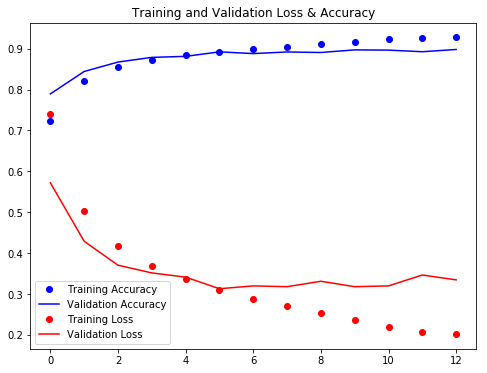

In [60]:
plot_acc_and_val(history_5)

#### Observations on Model 5
Model 5 performs better than the previous models (in all 4 training metrics), though it stopped after only 13 epochs. The plot shows that val_loss did reach a plateau, but perhaps a few more epochs would have given the model a slight improvement. Will adjust callbacks to decrease patience on learning rate and increase patience on early stopping. Will keep increased image size and larger training set, add another convolutional layer, and add another dense layer with dropout. 

In [69]:
model_5.save('Models/model_5_more_train_data.h5')

### Model 6
* add 1 convolutional layer
* add 1 dense layer with dropout
* adjust patience on callbacks

#### Adjust Callback Parameters 
Reduce patience for reducing Learning Rate and increase patience for Early Stopping

In [62]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=3, 
                              min_lr=0.001,
                              verbose=1)

early_stoppage = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=10, 
                               verbose=1, 
                               mode='auto', 
                               baseline=None, 
                               restore_best_weights=False)

In [65]:
model_6 = Sequential()
model_6.add(Conv2D(64, (3,3), 
                  input_shape=X.shape[1:], 
                  activation='relu',
                  padding='same'))
model_6.add(MaxPooling2D(2,2))

model_6.add(Conv2D(64, (4,4), activation='relu', padding='same'))
model_6.add(MaxPooling2D(2,2))

model_6.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(2,2))

model_6.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(2,2))

model_6.add(Flatten())
model_6.add(Dense(64, activation='relu'))
model_6.add(Dropout(0.3))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dropout(0.3))
model_6.add(Dense(4, activation='softmax'))

#### Model Summary

In [67]:
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 50, 50, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 64)        65600     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 256)         295168    
__________

In [66]:
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [68]:
start = datetime.datetime.now()

history_6 = model_6.fit(X_train, y_train,
                       callbacks=[reduce_lr, early_stoppage],
                       validation_split=0.2,
                       batch_size=32,
                       epochs=30)

elapsed = datetime.datetime.now() - start
print(f'Total time elapsed: {elapsed}')

Train on 60195 samples, validate on 15049 samples
Epoch 1/30
60195/60195 [==============================] - 363s 6ms/step - loss: 0.7665 - acc: 0.7051 - val_loss: 0.5581 - val_acc: 0.8012
Epoch 2/30
60195/60195 [==============================] - 350s 6ms/step - loss: 0.4739 - acc: 0.8340 - val_loss: 0.4018 - val_acc: 0.8573
Epoch 3/30
60195/60195 [==============================] - 348s 6ms/step - loss: 0.3892 - acc: 0.8651 - val_loss: 0.3329 - val_acc: 0.8823
Epoch 4/30
60195/60195 [==============================] - 332s 6ms/step - loss: 0.3392 - acc: 0.8852 - val_loss: 0.3231 - val_acc: 0.8874
Epoch 5/30
60195/60195 [==============================] - 359s 6ms/step - loss: 0.3069 - acc: 0.8945 - val_loss: 0.3274 - val_acc: 0.8833
Epoch 6/30
60195/60195 [==============================] - 354s 6ms/step - loss: 0.2802 - acc: 0.9047 - val_loss: 0.3084 - val_acc: 0.8949
Epoch 7/30
60195/60195 [==============================] - 374s 6ms/step - loss: 0.2507 - acc: 0.9142 - val_loss: 0.3468 - 

#### Comparison to Previous Models

In [74]:
model_6_results = [50, 4, 2, 'more layers', 19, 0.96, 0.1, 0.90, 0.4, '1:51']
append_df(df, 5, model_6_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36
3,40,5,2,dropout,20,0.90,0.29,0.86,0.48,1:29
4,50,3,1,increase img size,13,0.93,0.20,0.90,0.33,50
5,50,4,2,more layers,19,0.96,0.10,0.90,0.40,1:51


#### Train & Test Metrics

In [71]:
print_metrics(model_6, X_train, y_train, X_test, y_test)

75244/75244 [==============================] - 103s 1ms/step
Training loss: 0.138779150518756
75244/75244 [==============================] - 100s 1ms/step
Training accuracy: 0.9592259847929613
8361/8361 [==============================] - 11s 1ms/step
Test loss: 0.41002111081486187
8361/8361 [==============================] - 11s 1ms/step
Test accuracy: 0.9010883865708897


#### Accuracy & Loss vs. Epochs

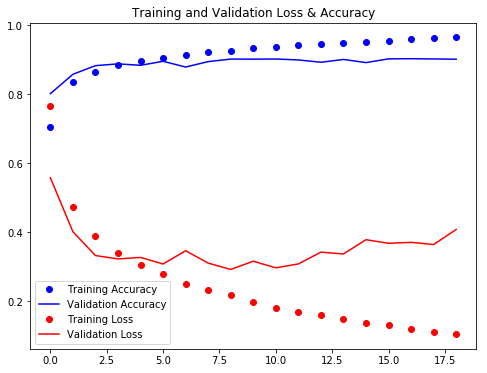

In [72]:
plot_acc_and_val(history_6)

#### Model 6 Observations
Adding layers improved training accuracy and reduced training loss, but there was no improvement in validation accuracy or loss. Validation loss actually increased, indicating overfitting. Reducing the dropout percentage and adjusting the callbacks to continue training when it probably should've stopped most likely led to the overfitting. Keeping the basic architecture of the model the same, while reverting back to a 0.5 dropout and the original callback parameters would show if these attributes were responsible for the overfitting. 

In [70]:
model_6.save('Models/model_6_moar_layerz.h5')

#### Reverse one-hot encoding
Revert y-values to the the original integers corresponding to class indices in order to evaluate predictions.

In [75]:
y_pred = model_6.predict(X_test)

In [81]:
# just to check that I am using this correctly
sample_y_preds = y_pred[:3]
sample_y_test = y_test[:3]
print(sample_y_preds)
print(sample_y_test)

[[7.2729070e-18 1.0000000e+00 2.9092839e-12 3.2552062e-08]
 [2.5271588e-06 9.9717772e-01 3.2787386e-05 2.7870035e-03]
 [5.2496420e-25 1.0000000e+00 9.1013899e-23 8.4577748e-15]]
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [83]:
y_pred_reverse = [np.argmax(y, axis=None, out=None) for y in sample_y_preds]
y_test_reverse = [np.argmax(y, axis=None, out=None) for y in sample_y_test]

In [84]:
print(y_pred_reverse)
print(y_test_reverse)

[1, 1, 1]
[1, 3, 1]


In [85]:
y_preds_reversed = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_true_reversed = [np.argmax(y, axis=None, out=None) for y in y_test]

#### Confusion Matrix

In [94]:
cm = confusion_matrix(y_true_reversed, y_preds_reversed)
cm

array([[2507,   29,  105,   76],
       [  24, 3535,   31,   70],
       [  75,   79,  957,   16],
       [ 169,  132,   21,  535]])

In [96]:
class_names = ['normal', 'cnv', 'dme', 'drusen']

In [97]:
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm

,normal,cnv,dme,drusen
normal,2507,29,105,76
cnv,24,3535,31,70
dme,75,79,957,16
drusen,169,132,21,535


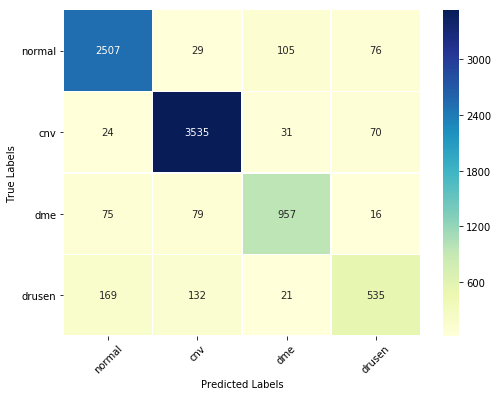

In [100]:
fig = plt.figure(figsize=(8,6))
hm = sns.heatmap(data=df_cm, annot=True, cbar=True, cmap='YlGnBu', linewidths=0.5, fmt='d')
hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0)
hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=45)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

#### Confusion Matrix Observations
The confusion matrix reflects the number of samples in each class. The model is able to predict CNV images the best because that class had the most data. Conversely, the model performed poorly on Drusen images because that class had the smallest amount of data samples, reducing its ability to learn how to predict this class. 

### Model 7
* Goal: reduce overfitting seen in the previous model
* Revert patience values on callbacks
* Increase dropout values to 0.5
* Decrease epochs

#### Adjust Callback Parameters
Revert to earlier patience values to reduce overfitting.

In [101]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001,
                              verbose=1)

early_stoppage = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=7, 
                               verbose=1)

In [102]:
model_7 = Sequential()
model_7.add(Conv2D(64, (3,3), 
                  input_shape=X.shape[1:], 
                  activation='relu',
                  padding='same'))
model_7.add(MaxPooling2D(2,2))

model_7.add(Conv2D(64, (4,4), activation='relu', padding='same'))
model_7.add(MaxPooling2D(2,2))

model_7.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(2,2))

model_7.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(2,2))

model_7.add(Flatten())
model_7.add(Dense(64, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(64, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(4, activation='softmax'))

In [103]:
model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [104]:
start = datetime.datetime.now()

history_7 = model_7.fit(X_train, y_train,
                     callbacks=[reduce_lr, early_stoppage],
                     batch_size=32,
                     epochs=20,
                     validation_split=0.2)

elapsed = datetime.datetime.now() - start
print(f'Total time elapsed: {elapsed}')

Train on 60195 samples, validate on 15049 samples
Epoch 1/20
60195/60195 [==============================] - 342s 6ms/step - loss: 0.7953 - acc: 0.6972 - val_loss: 0.6687 - val_acc: 0.7545
Epoch 2/20
60195/60195 [==============================] - 350s 6ms/step - loss: 0.5942 - acc: 0.7925 - val_loss: 0.4683 - val_acc: 0.8239
Epoch 3/20
60195/60195 [==============================] - 341s 6ms/step - loss: 0.4759 - acc: 0.8380 - val_loss: 0.3847 - val_acc: 0.8634
Epoch 4/20
60195/60195 [==============================] - 337s 6ms/step - loss: 0.4119 - acc: 0.8601 - val_loss: 0.3435 - val_acc: 0.8819
Epoch 5/20
60195/60195 [==============================] - 342s 6ms/step - loss: 0.3725 - acc: 0.8760 - val_loss: 0.3305 - val_acc: 0.8858
Epoch 6/20
60195/60195 [==============================] - 352s 6ms/step - loss: 0.3452 - acc: 0.8854 - val_loss: 0.3522 - val_acc: 0.8772
Epoch 7/20
60195/60195 [==============================] - 343s 6ms/step - loss: 0.3218 - acc: 0.8931 - val_loss: 0.3264 - 

#### Train & Test Metrics

In [106]:
print_metrics(model_7, X_train, y_train, X_test, y_test)

75244/75244 [==============================] - 113s 1ms/step
Training loss: 0.16527045492870432
75244/75244 [==============================] - 112s 1ms/step
Training accuracy: 0.9427462654797935
8361/8361 [==============================] - 13s 2ms/step
Test loss: 0.36724562323303006
8361/8361 [==============================] - 12s 1ms/step
Test accuracy: 0.8936730056355949


#### Accuracy & Loss vs. Epochs

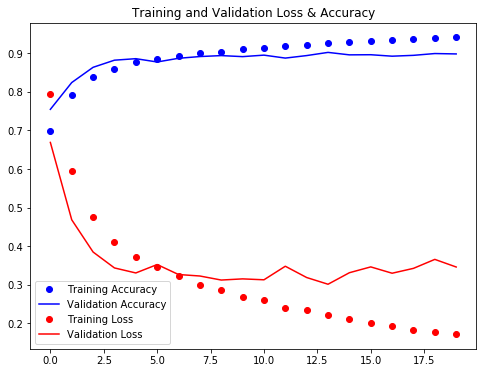

In [109]:
plot_acc_and_val(history_7)

After 10 epochs, training and validation loss diverge (though not as much as in Model 6), but training and validation accuracy are similar in this model.

#### Confusion Matrix

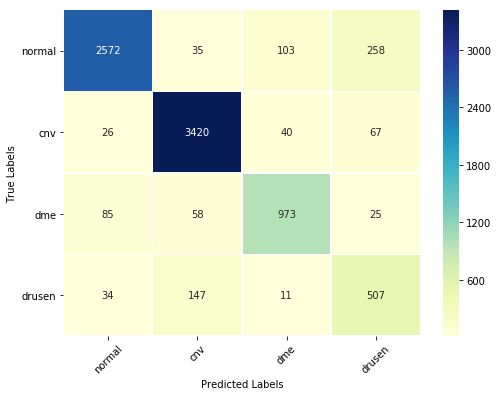

In [112]:
y_preds = model_7.predict(X_test)

# run confusion matrix function first
plot_confusion_matrix(y_test, y_preds)

Like the previous confusion matrix, class size in Model 7 also seems to have the biggest influence on true positives.

#### Precision Rates by Class

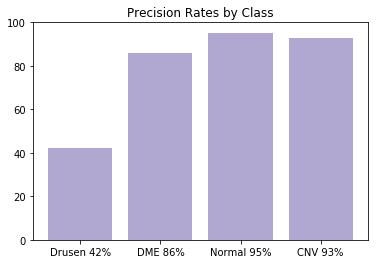

In [13]:
# precision rates calculated by class - TP / (TP + FP)

fig = plt.figure()
fig.patch.set_facecolor('white')
x = np.arange(4)
labels = ['Drusen 42%', 'DME 86%', 'Normal 95%', 'CNV 93%']
amounts = [drusen_precision, dme_precision, normal_precision, cnv_precision]

plt.bar(x, amounts, align='center', color='#B1A8D2')
plt.ylim([0, 100])
plt.xticks(x, labels)
plt.title('Precision Rates by Class')
plt.show()

In [105]:
model_7.save('Models/model_7_more_dropout.h5')

#### Comparison to Past Models

In [114]:
model_7_results = [50, 4, 2, 'more dropout', 20, 0.94, 0.17, 0.90, 0.35, '1:55']
append_df(df, 6, model_7_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36
3,40,5,2,dropout,20,0.90,0.29,0.86,0.48,1:29
4,50,3,1,increase img size,13,0.93,0.20,0.90,0.33,50
5,50,4,2,more layers,19,0.96,0.10,0.90,0.40,1:51
6,50,4,2,more dropout,20,0.94,0.17,0.90,0.35,1:55


#### Model 7 Observations

Model 7 shows a better fit when comparing training and validation data. The testing scores were slightly better than in Model 6, but because the test set is so small, the difference could be random. The increased dropout probably helped the fit and also allowed the model to train for more epochs before early stopping. Training for more than 20 epochs would probably increase the training accuracy but might also lead to more overfitting. Model 6 tested slightly better on (the smallest class) Drusen samples, but worse on DME samples - not much of a difference so could also be random. 

## V. Conclusions & Recommendations

All of the models had good accuracy scores between 87-97% for training data and 84-90% for validation data. The later models (Model 5 and beyond) had similar test accuracy scores around 90% which was an improvement over earlier models. Model 5 was also the first model to train on larger training and validation sets due to decreasing the holdout test size to 10% of the overall data. As usual, more data leads to better model performance. This is especially apparent in the Confusion Matrices, which clearly show that the model can more accurately identify CNV images - which was the class with the largest amount of samples. The models performed poorly on identifying Drusen images mostly likely because this was the smallest class. Balanced classes with more images could greatly improve model performance.

### Recommendations to Improve Model 
* More data for each class, or at the very least - more data for the smaller classes of Drusen and DME
* Balanced classes
* More information on disease progression and when the images were taken
    * Were the images of the non-normal classes taken in the early or late stages of disease?
    * If the non-normal class images were all taken in the later stages when changes are more prominent, the model will not perform well when introduced to early-stage non-normal images
    * The model would need images from a wide range of disease progression if it is to catch problems early
* The addition of patient information
* With enough computational resources, larger colored images could possibly be used successfully with available pre-trained models

### Recommendations to Improve Diagnosis & Patient Care with Model
* Additional data for each patient
    * Family history of retinal disease
    * Family history of medical problems that can lead to retinal disease (i.e. Diabetes, Metabolic Syndrome)
    * Patient's age, ethnicity, gender, and other medical history and demographics 
        * Risk of Macular Degeneration and Glaucoma increases with age
        * Caucasians have a higher risk of Macular Degeneration
        * African Americans, American Indians, and Mexican Americans have a higher risk of Diabetes
* Overall Risk Factor Score that takes additional patient information into account
    * An image that the model classifies as DME - or could possibly be DME - would appear to the clinician as having different risk levels when combined with other factors

## Risk Factor Score
Use `predict_proba` to classify different levels of Risk - to be used in conjunction with other patient risk factors

#### Load final model to make predictions

In [14]:
final_model = load_model('Models/model_7_more_dropout.h5')

In [15]:
y_test_proba = final_model.predict_proba(X_test)

In [31]:
y_test_proba.shape

(8361, 4)

#### Scale prediction values

In [16]:
# would like to see a probability score that I can actually make sense of 
# (I know that np.interp doesn't stand for interpretation)
interpretable_y_test_proba = np.interp(y_test_proba, (y_test_proba.min(), y_test_proba.max()), (0.1, 1.0))

In [17]:
interpretable_y_test_proba[251]

array([0.31673359, 0.10133523, 0.77652446, 0.10540675])

In [60]:
# for reference
class_names = ['normal', 'cnv', 'dme', 'drusen']

#### Figure out how this works

In [21]:
for i, arry in enumerate(interpretable_y_test_proba[:1]):
    for j, probs in enumerate(arry):
        if probs > 0.5:
            print(f'High risk of class {j} at index {i}')

High risk of class 1 at index 0


In [24]:
# filter out class 0's since those are normal

for i, arry in enumerate(interpretable_y_test_proba[:5]):
    for j, probs in enumerate(arry):
        if j!= 0:
            if probs > 0.5:
                print(f'High risk of class {j} at index {i}')

High risk of class 1 at index 0
High risk of class 3 at index 1
High risk of class 1 at index 2


In [26]:
# identify classes!

for i, arry in enumerate(interpretable_y_test_proba[:5]):
    for j, probs in enumerate(arry):
        if j == 1:
            if probs < 0.3:
                print(f'Low risk of CNV at index {i}')
            elif probs > 0.31 and probs < 0.6:
                print(f'Medium risk of CNV at index {i}')
            else:
                print(f'High risk of CNV at index {i}')

High risk of CNV at index 0
Medium risk of CNV at index 1
High risk of CNV at index 2
Low risk of CNV at index 3
Low risk of CNV at index 4


#### Classify every probability score into low, medium, or high risk for CNV, DME, and Drusen
This would need to be a function but would also eventually need to be a function that can communicate with a SQL Database and then ideally with a dashboard. The cell below already has 9 lists which would easily and immediately become difficult to organize due to accidentally replacing existing lists or having to add weird strings to list names and then would end up as a bunch of weirdly-named lists with no organization at all. The risk factor data contained in this notebook alone could be organized better with a dictionary, but the idea of the Risk Factor Score is to combine it with sources of other patient information (with patient ids).

In [32]:
low_risk_cnv = []
medium_risk_cnv = []
high_risk_cnv = []

low_risk_dme = []
medium_risk_dme = []
high_risk_dme = []

low_risk_drusen = []
medium_risk_drusen = []
high_risk_drusen = []


for i, arry in enumerate(interpretable_y_test_proba):
    for j, probs in enumerate(arry):
        
        if j == 1:
            if probs < 0.3:
                # print(f'Low risk of CNV at index {i}')
                low_risk_cnv.append(i)
            elif probs > 0.31 and probs < 0.6:
                # print(f'Medium risk of CNV at index {i}')
                medium_risk_cnv.append(i)
            else:
                # print(f'High risk of CNV at index {i}')
                high_risk_cnv.append(i)
                
        elif j == 2:
            if probs < 0.3:
                # print(f'Low risk of DME at index {i}')
                low_risk_dme.append(i)
            elif probs > 0.31 and probs < 0.6:
                # print(f'Medium risk of DME at index {i}')
                medium_risk_dme.append(i)
            else:
                # print(f'High risk of DME at index {i}')
                high_risk_dme.append(i)
                
        elif j == 3:
            if probs < 0.3:
                # print(f'Low risk of Drusen at index {i}')
                low_risk_drusen.append(i)
            elif probs > 0.31 and probs < 0.6:
                # print(f'Medium risk of Drusen at index {i}')
                medium_risk_drusen.append(i)
            else:
                # print(f'High risk of Drusen at index {i}')
                high_risk_drusen.append(i)

In [34]:
print(f'Number of low risk DME scans: {len(low_risk_dme)}')
print(f'Number of medium risk Drusen scans: {len(medium_risk_drusen)}')
print(f'Number of high risk CNV scans: {len(high_risk_cnv)}')

Number of low risk DME scans: 7052
Number of medium risk Drusen scans: 308
Number of high risk CNV scans: 3513


## VI. Incriminating Evidence

In [ ]:
# I hope this is still correct
img_classes = ['normal', 'cnv', 'dme', 'drusen']

In [89]:
# compare class sizes
cnv_imgs = len(os.listdir('Data/cnv'))
dme_imgs = len(os.listdir('Data/dme'))
drusen_imgs = len(os.listdir('Data/drusen'))
normal_imgs = len(os.listdir('Data/normal'))

print(f'Number of cnv images: {cnv_imgs}')
print(f'Number of dme images: {dme_imgs}')
print(f'Number of drusen images: {drusen_imgs}')
print(f'Number of normal images: {normal_imgs}')

Number of cnv images: 37216
Number of dme images: 11422
Number of drusen images: 8620
Number of normal images: 26348


In [88]:
y_train_reversed = [np.argmax(y, axis=None, out=None) for y in y_train]

In [92]:
print(Counter(y_train_reversed))
print(Counter(y_true_reversed))

Counter({1: 33556, 0: 23630, 2: 10295, 3: 7763})
Counter({1: 3660, 0: 2717, 2: 1127, 3: 857})


In [ ]:
# 0 = normal
# 1 = cnv
# 2 = dme
# 3 = drusen
# I know I'm a Neanderthal for counting these out, BUT I HAD TO BE SURE!!!!!!

In [7]:
# calculating accuracy per class. . . by hand again, sorry
# accuracy = (TP + TN) / (TP + TN + FP + FN)
# (TP + TN) will be the same for every class - it's just the total of the diagonal cells
# TP + TN = 7472
# denominator for every class will be 7472 + the sum of the other cells in its row and column

drusen_acc = round(7472 / (7472 + 542),2) * 100
dme_acc = round(7472 / (7472 + 322),2) * 100
normal_acc = round(7472 / (7472 + 541),2) * 100
cnv_acc = round(7472 / (7472 + 373),2) * 100

print(f'Drusen acc: {drusen_acc}')
print(f'DME acc: {dme_acc}')
print(f'Normal acc: {normal_acc}')
print(f'CNV acc: {cnv_acc}')
print('')

# hmm, that shows the model predicted normal pictures just as well as drusen, which is not what I was looking
# for
# maybe precision? TP / (TP + FP)

drusen_precision = round(507 / (857 + 350),2) * 100
dme_precision = round(973 / (973 + 154),2) * 100
normal_precision = round(2572 / (2572 + 145),2) * 100
cnv_precision = round(3420 / (3420 + 240),2) * 100

print(f'Drusen precision: {drusen_precision}')
print(f'DME precision: {dme_precision}')
print(f'Normal precision: {normal_precision}')
print(f'CNV precision: {cnv_precision}')

Drusen acc: 93.0
DME acc: 96.0
Normal acc: 93.0
CNV acc: 95.0

Drusen precision: 42.0
DME precision: 86.0
Normal precision: 95.0
CNV precision: 93.0


In [77]:
# Evidence of a 4+ hour mistake
# start = datetime.datetime.now()

# model.fit(X_train, y_train, epochs=10, validation_split=0.2)
# elapsed = datetime.datetime.now() - start
# print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/10
53507/53507 [==============================] - 1617s 30ms/step - loss: 0.8691 - acc: 0.6603 - val_loss: 0.7929 - val_acc: 0.6966
Epoch 2/10
53507/53507 [==============================] - 1507s 28ms/step - loss: 0.7538 - acc: 0.7102 - val_loss: 0.8290 - val_acc: 0.6850
Epoch 3/10
53507/53507 [==============================] - 1453s 27ms/step - loss: 0.7128 - acc: 0.7264 - val_loss: 0.7220 - val_acc: 0.7197
Epoch 4/10
53507/53507 [==============================] - 1433s 27ms/step - loss: 0.6874 - acc: 0.7384 - val_loss: 0.7191 - val_acc: 0.7265
Epoch 5/10
53507/53507 [==============================] - 1508s 28ms/step - loss: 0.6709 - acc: 0.7432 - val_loss: 0.6981 - val_acc: 0.7319
Epoch 6/10
53507/53507 [==============================] - 1491s 28ms/step - loss: 0.6559 - acc: 0.7494 - val_loss: 0.7129 - val_acc: 0.7297
Epoch 7/10
53507/53507 [==============================] - 1528s 29ms/step - loss: 0.6442 - acc: 0.7544 - val_l

In [83]:
# model.save('Models/vgg19_10_epochs.h5')